***Importing Libraries***

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

***Reading and Processing Data***

In [2]:
raw_data = yf.download(tickers='AAPL', period='5y')
df = raw_data.copy()

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000778,134247600
2017-01-10,29.692499,29.844999,29.575001,29.777500,28.029020,97848400
2017-01-11,29.684999,29.982500,29.650000,29.937500,28.179623,110354400
2017-01-12,29.725000,29.825001,29.552500,29.812500,28.061960,108344800
2017-01-13,29.777500,29.905001,29.702499,29.760000,28.012548,104447600


In [4]:
size = int(len(df) * 0.8)
train, test = df[0:size], df[size:len(df)]

In [5]:
X_train = train.drop(['Close'], axis=1)
y_train = train['Close']
X_test = test.drop(['Close'], axis=1)
y_test = test['Close']

In [6]:
y_train.values.reshape(-1, 1)

array([[ 29.74749947],
       [ 29.77750015],
       [ 29.9375    ],
       ...,
       [131.00999451],
       [126.59999847],
       [130.91999817]])

***Scaling the Data***

In [7]:
#Scaling the data so that svr can converge the data even faster
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.fit_transform(X_test)
y_train_scaled = scale.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scale.fit_transform(y_test.values.reshape(-1, 1))

***Tuning with RBF Kernel***

In [9]:
gsc = GridSearchCV(
    estimator=SVR(kernel='rbf'),
    param_grid={
        'C': [0.001, 0.01, 0.1, 1, 100, 1000],
        'epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'gamma': [0.0001, 0.001, 0.1, 1, 100, 1000]
    })

In [13]:
grid_result = gsc.fit(X_train_scaled, y_train_scaled)
best_params = grid_result.best_params_

In [14]:

rbf_svr = SVR(kernel='rbf',
                C=best_params["C"],
                epsilon=best_params["epsilon"],
                gamma=best_params["gamma"])

In [15]:
rbf_svr.fit(X_train_scaled, y_train_scaled)

SVR(C=1000, epsilon=0.001, gamma=0.0001)

In [16]:
rbf_pred = rbf_svr.predict(X_test_scaled)

In [14]:
from sklearn.metrics import mean_squared_error

In [19]:
rbf_rmse = np.sqrt(mean_squared_error(y_test_scaled, rbf_pred))
rbf_rmse

0.025012462622669446

***Tuning with Linear Kernel***

In [10]:
#Reduced hyperparameter ranges as it is taking a long time for execution. The parameter ranges are set based on best values from rbf_svr
gsc_linear = GridSearchCV(
    estimator=SVR(kernel='linear'),
    param_grid={
        'C': [0.1, 1, 100],
        'epsilon': [0.001, 0.01, 0.1, 1],
        'gamma': [0.0001, 0.001, 0.1, 1]
    })

In [11]:
grid_result_linear = gsc_linear.fit(X_train_scaled, y_train_scaled)
best_params_linear = grid_result_linear.best_params_

In [12]:
linear_svr = SVR(kernel='linear',
                C=best_params_linear["C"],
                epsilon=best_params_linear["epsilon"],
                gamma=best_params_linear["gamma"])

In [13]:
linear_svr.fit(X_train_scaled, y_train_scaled)

SVR(C=0.1, epsilon=0.001, gamma=0.0001, kernel='linear')

In [14]:
linear_pred = linear_svr.predict(X_test_scaled)

In [17]:
linear_rmse = np.sqrt(mean_squared_error(y_test_scaled, linear_pred))
linear_rmse

0.03136060328212074

***Tuning with Polynomial Kernel***

In [8]:
gsc_poly = GridSearchCV(
    estimator=SVR(kernel='poly'),
    param_grid={
        'C': [0.1, 1, 100],
        'epsilon': [0.001, 0.01, 0.1, 1],
        'gamma': [0.0001, 0.001, 0.1, 1]
    })

In [9]:
grid_result_poly = gsc_poly.fit(X_train_scaled, y_train_scaled)
best_params_poly = grid_result_poly.best_params_

In [10]:
poly_svr = SVR(kernel='poly',
                C=best_params_poly["C"],
                epsilon=best_params_poly["epsilon"],
                gamma=best_params_poly["gamma"])

In [11]:
poly_svr.fit(X_train_scaled, y_train_scaled)

SVR(C=100, epsilon=0.001, gamma=0.001, kernel='poly')

In [12]:
poly_pred = poly_svr.predict(X_test_scaled)

In [15]:
poly_rmse = np.sqrt(mean_squared_error(y_test_scaled, poly_pred))
poly_rmse

1.038405646241796

After tuning the hyperparameters for different SVR (rbf, linear, poly) models, the rmse for SVR with rbf kernel is the lowest. Hence using the best parameters of rbf kernel for SVR.

***Prediction with SVR(rbf kernel)***

In [16]:
svr_model = SVR(kernel='rbf', C=1000, epsilon=0.001, gamma=0.0001)

In [17]:
svr_model.fit(X_train_scaled, y_train_scaled)

SVR(C=1000, epsilon=0.001, gamma=0.0001)

In [18]:
predict_svr = svr_model.predict(X_test_scaled)
rmse_svr = np.sqrt(mean_squared_error(y_test_scaled, predict_svr))
rmse_svr

0.024898659883014408

Need to inverse the transformation of the data to get the original values.

In [19]:
prediction = scale.inverse_transform(predict_svr)
prediction

array([131.52270756, 129.07695197, 128.50586271, 130.63804796,
       129.03123454, 127.55531068, 127.8206543 , 131.6123486 ,
       136.8619543 , 138.30861744, 141.24895708, 142.53531603,
       141.58691482, 137.47677544, 131.78389098, 133.43496848,
       134.92071259, 133.84251999, 136.58249948, 136.51353992,
       136.45313241, 136.25401634, 135.27194856, 134.89135935,
       135.08589844, 133.35759166, 130.76840738, 129.31158313,
       129.80174535, 126.57427629, 124.42621978, 124.78940698,
       121.76378208, 122.1041517 , 127.20034028, 125.56626264,
       122.65210084, 120.50982988, 120.80558458, 117.02943042,
       121.31051606, 120.40064952, 122.26028658, 120.99732979,
       123.66762246, 125.87555399, 124.65858199, 121.011923  ,
       120.55082507, 123.3760272 , 122.97820468, 120.64126491,
       120.91176372, 121.11196403, 121.7793159 , 120.0832837 ,
       122.54960296, 123.31902848, 125.69987431, 126.42018874,
       127.62183861, 130.17188412, 132.54970515, 131.28

In [20]:
test_copy = test.copy()
test_copy['Prediction'] = prediction

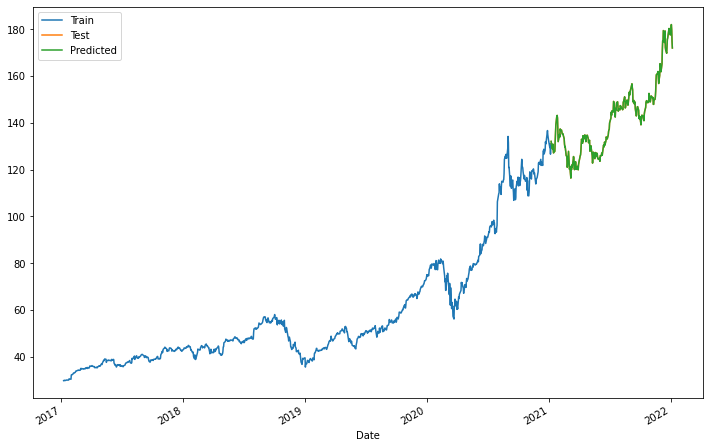

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
train.Close.plot(label='Train', legend=True)
test.Close.plot(label='Test', legend=True)
test_copy.Close.plot(label='Predicted', legend=True)
plt.legend()
plt.show()